In [1]:
import os
import cv2
import numpy as np
import random

from tqdm import tqdm
from utils import (
    overlay_image_with_blend, 
    gaussian_kernel, zip_folder)

from utils.algorithms import (
    perlin_noise, 
    generate_parallel_or_perpendicular_lines)

In [2]:
def entre(min_val, max_val, integer=False):
    """ Valor aleatorio entre [min_val, max_val] """
    if isinstance(min_val,int): return random.randint(min_val,max_val)
    if integer: return random.randint(int(min_val),int(max_val))
    return random.uniform(min_val,max_val)

def generate_images(shape_image_base=(512, 512), gaussian_size_low=4, gaussian_size_high=40, num_lines_range=(2, 6)):
    """
    Generate images with random parallel or perpendicular lines and apply Gaussian blur and Perlin noise.

    Parameters:
    shape_image_base (tuple): Base shape of the image (height, width).
    gaussian_size_low (int): Minimum size of the Gaussian kernel.
    gaussian_size_high (int): Maximum size of the Gaussian kernel.
    num_lines_range (tuple): Range for the number of lines to generate (min, max).

    Returns:
    tuple: Generated images (img, img_background, img_pretil_binary, img_pretil).
    """
    img = np.zeros(shape_image_base)
    img_tmp = np.zeros(shape_image_base)
    img_pretil = np.zeros(shape_image_base)
    img_pretil_binary = np.zeros(shape_image_base)

    # Generate between 2 and 6 parallel or perpendicular lines
    num_lines = np.random.randint(num_lines_range[0], num_lines_range[1] + 1)
    lines = generate_parallel_or_perpendicular_lines(shape_image_base, num_lines)
    
    # Overlay the lines on the image
    for line in lines:
        img_line = np.zeros(shape_image_base)
        random_size = entre(gaussian_size_low, gaussian_size_high, integer=True)
        for point in line:
            factor = entre(0.5,1)
            if int(random_size * factor) < 2:
                continue
            gaussian = gaussian_kernel(int(random_size * factor), normalize=True)
            #print(gaussian.shape, np.max(gaussian))
            img_line += overlay_image_with_blend(img_tmp, gaussian, position=point)
        img_line = img_line / np.max(img_line) * entre(0.5, 2.5)   
        img = np.maximum(img, img_line)
    
    img_pretil = img.copy()
    img_pretil_binary = np.where(img >= 0.1, 1, 0)
    img_background = 1 - img_pretil_binary  
    img_pretil = np.clip(img_pretil, -10, 10)
    noise = perlin_noise((512, 512, 1), octaves=(entre(0.01, 0.02), entre(0.02,0.04), entre(0.04,0.08), entre(0.08, 0.1), entre(0.1,0.2), entre(0.2,0.3), entre(0.3,1))) * entre(0.1, 0.3)
    img += noise
    img = np.clip(img, -10, 10)
    
    return img, img_background, img_pretil_binary, img_pretil

In [3]:
num_images = 1000
dataset_path = 'dataset_3'

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
#else:
#    raise FileExistsError(f'Folder {dataset_path} already exists. Please remove it before running this script.')

gsd = 0.1  # Ground Sampling Distance (m/px)
shape_image_base = (512, 512)
pretril_size_low = np.round(0.4 / gsd)
pretil_size_high = np.round(4 / gsd)

for idx in tqdm(range(num_images)):
    img, img_backgound, img_pretil_binary, img_pretil = generate_images(shape_image_base,pretril_size_low, pretil_size_high)
    img_backgound = (img_backgound * 255).astype(np.uint8)
    img_pretil_binary = (img_pretil_binary * 255).astype(np.uint8)
    img_pretil = img_pretil.astype(np.half) 
    img = img.astype(np.half)

    np.savez_compressed(f'{dataset_path}/img_{idx}.npz', img)
    cv2.imwrite(f'{dataset_path}/img_backgound_{idx}.png', img_backgound)
    cv2.imwrite(f'{dataset_path}/img_pretil_binary_{idx}.png', img_pretil_binary)
    np.savez_compressed(f'{dataset_path}/img_pretil_{idx}.npz', img_pretil)
    
    #cv2.imwrite(f'{dataset_path}/img_pretil_{idx}.png', img_pretil)

100%|██████████| 1000/1000 [12:33<00:00,  1.33it/s]


In [4]:
zip_folder(dataset_path, f'{dataset_path}.zip')

Zipping files: 100%|██████████| 4000/4000 [00:20<00:00, 199.85file/s]


(512, 512) -0.1923 2.574 float16


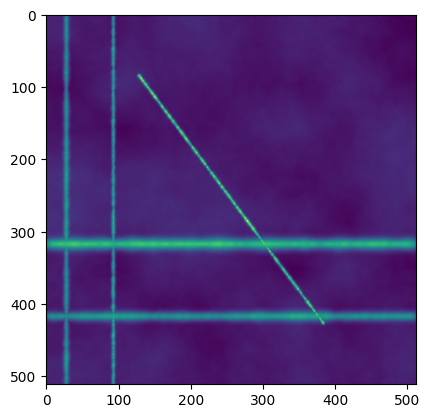

In [5]:
import matplotlib.pyplot as plt

img = np.load('dataset_3/img_1.npz')['arr_0']
print(img.shape,np.min(img),np.max(img),img.dtype)
plt.imshow(img)


(512, 512) -0.1923 2.574 float16


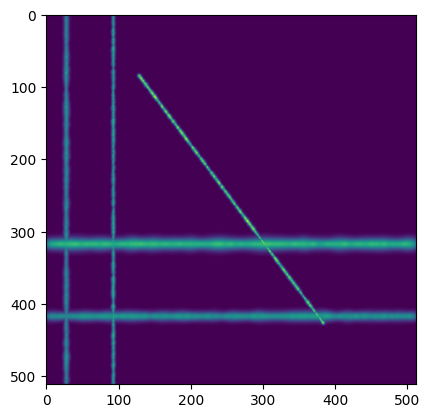

In [6]:
img_pretil = np.load('dataset_3/img_pretil_1.npz')['arr_0']
print(img.shape,np.min(img),np.max(img),img.dtype)
plt.imshow(img_pretil)